# Argon + visualization

In [ ]:
""" Pure Python implementation of the Argon2 password hash.

    If you can, use the `argon2_cffi' or `argon2' bindings.

    Bas Westerbaan <bas@westerbaan.name> """


import six
from six.moves import range
from six import BytesIO

import struct
import binascii
import multiprocessing
import multiprocessing.dummy

__all__ = [
    'argon2',
    'ARGON2D',
    'ARGON2I',
    'ARGON2_DEFAULT_VERSION',
    'ARGON2_VERSIONS',
    'Argon2Error',
    'Argon2ParameterError']

ARGON2D  = 0
ARGON2I  = 1
ARGON2ID = 2

ARGON2_VERSIONS = (0x10, 0x13)
ARGON2_DEFAULT_VERSION = ARGON2_VERSIONS[-1]
ARGON2_TYPES = (ARGON2D, ARGON2I, ARGON2ID)

i_primes = []
j_primes = []

class Argon2Error(Exception):
    pass

class Argon2ParameterError(Argon2Error):
    pass

def argon2(password, salt, time_cost, memory_cost, parallelism,
                tag_length=32, secret=b'', associated_data=b'',
                type_code=ARGON2I, threads=None, version=ARGON2_DEFAULT_VERSION,
                use_threads=False):
    """ Compute the Argon2 hash for *password*.

    :param bytes password: Password to hash
    :param bytes salt: A salt.  Should be random and different for each
        password.
    :param int time_cost: Number of iterations to use.
    :param int memory_cost: Amount of kibibytes of memory to use.
    :param int parallelism: Amount of threads that can contribute to
        the computation of the hash at the same time.

    Optional arguments:

    :param int tag_length: Length of the hash returned
    :param bytes secret: Optional secret to differentiate hash
    :param bytes associated_data: Optional associated data
    :param int type: variant of argon2 to use.  Either ARGON2I or ARGON2D
    :param int threads: number of threads to use to compute the hash.
    :param bool use_threads: if true, signal multiprocessing to use threads
        rather than processes.
    :param int version: version of argon2 to use.  At the moment either
        0x10 for v1.0 or 0x13 for v1.3

    :rtype: bytes """
    if threads is None:
        threads = parallelism
    if parallelism <= 0:
        raise Argon2ParameterError("parallelism must be strictly positive")
    if threads <= 0:
        raise Argon2ParameterError("threads must be strictly positive")
    if time_cost <= 0:
        raise Argon2ParameterError("time_cost must be strictly positive")
    if memory_cost < 8 * parallelism:
        raise Argon2ParameterError("memory_cost can't be less than 8"
                                    " times the number of lanes")
    if type_code not in ARGON2_TYPES:
        raise Argon2ParameterError("type_code %s not supported" % type_code)
    if version not in ARGON2_VERSIONS:
        raise Argon2ParameterError("version %s not supported" % version)
        
    i_primes = []
    j_primes = []

    threads = min(parallelism, threads)

    if threads == 1:
        worker_pool = None
    else:
        if use_threads:
            Pool = multiprocessing.dummy.Pool
        else:
            Pool = multiprocessing.Pool
        worker_pool = Pool(processes=threads)

    # Compute the pre-hasing digest
    h = Blake2b()
    h.update(struct.pack("<iiiiii", parallelism,
                                    tag_length,
                                    memory_cost,
                                    time_cost,
                                    version,
                                    type_code))
    h.update(struct.pack("<i", len(password)))
    h.update(password)
    h.update(struct.pack("<i", len(salt)))
    h.update(salt)
    h.update(struct.pack("<i", len(secret)))
    h.update(secret)
    h.update(struct.pack("<i", len(associated_data)))
    h.update(associated_data)
    H0 = h.digest()

    m_prime = (memory_cost // (4 * parallelism)) * (4 * parallelism)
    q = m_prime // parallelism  # lane_length
    segment_length = q // 4

    # Allocate the matrix.
    B = [[None for j in range(q)] for i in range(parallelism)]

    # The blocks in Argon2 are arranged in a matrix.  For each thread,
    # there is a row, which is also called a lane.  The number of
    # columns depends on the memory_cost.
    # There will be time_cost passes over the whole matrix.
    # The colums are put into groups of four, called slices.
    # The intersection of a lane with a slice is called a segment.
    # The matrix is filled one slice at the time.  The segments within
    # a slice can be computed in parallel.
    for t in range(time_cost):
        for segment in range(4):
            if not worker_pool:
                for i in range(parallelism):
                    _, (i_indexes, j_indexes) = _fill_segment(B, t, segment, i, type_code, segment_length,
                                H0, q, parallelism, m_prime, time_cost, version)
                    i_primes += i_indexes
                    j_primes += j_indexes
                    #print(f'Result of lane {i} and segment {segment}: {len(i_indexes)}')
                continue

            handles = [None]*parallelism
            for i in range(parallelism):
                handles[i] = worker_pool.apply_async(_fill_segment,
                            (B, t, segment, i, type_code, segment_length, H0,
                                q, parallelism, m_prime, time_cost, version))
            for i in range(parallelism):
                new_blocks, (i_indexes, j_indexes) = handles[i].get()
                
                i_primes += i_indexes
                j_primes += j_indexes

                for index in range(segment_length):
                    B[i][segment * segment_length + index] = new_blocks[index]

    if worker_pool:
        # don't let workers sit around until pool is GC'd
        worker_pool.close()

    B_final = b'\0' * 1024

    for i in range(parallelism):
        B_final = xor1024(B_final, B[i][q-1])

    return _H_prime(B_final, tag_length), (i_primes, j_primes)

def _fill_segment(B, t, segment, i, type_code, segment_length, H0,
                        q, parallelism, m_prime, time_cost, version):
    # Argon2i computes a bunch of pseudo-random numbers
    # for every segment.
    data_independant = ((type_code == ARGON2I)
            or (type_code == ARGON2ID and t == 0 and segment <= 1))
    if data_independant:
        # See `generate_addresses' in reference implementation
        # and section 3.3 of the specification.
        pseudo_rands = []
        ctr = 0  # `i' in the specification
        while len(pseudo_rands) < segment_length:
            ctr += 1
            address_block = _compress(b'\0'*1024, _compress(b'\0'*1024,
                                struct.pack('<QQQQQQQ', t, i, segment, m_prime,
                                                    time_cost, type_code, ctr)
                                    + b'\0'*968))
            for addr_i in range(0, 1024, 8):
                pseudo_rands.append(struct.unpack('<II',
                            address_block[addr_i:addr_i+8]))
                
    i_primes = []
    j_primes = []

    for index in range(segment_length):
        j = segment * segment_length + index
        if t == 0 and j < 2:
            # First two columns are special.
            B[i][j] = _H_prime(H0 + struct.pack('<II', j, i), 1024)
            continue

        # See `section 3.3. Indexing' of argon2 spec.
        # First, we derive two pseudo-random values from the current
        # state.  This is where Argon2i and Argon2d differ.
        if data_independant:
            J1, J2 = pseudo_rands[index]
        else:
            J1, J2 = struct.unpack_from('<II', B[i][(j-1)%q][:8])

        # Using the pseudo-random J1 and J2, we pick a reference
        # block to mix with the previous one to create the next.
        i_prime = i if t == 0 and segment == 0 else J2 % parallelism

        if t == 0:
            if segment == 0 or i == i_prime:
                ref_area_size = j - 1
            elif index == 0:
                ref_area_size = segment * segment_length - 1
            else:
                ref_area_size = segment * segment_length
        elif i == i_prime:  # same_lane
            ref_area_size = q - segment_length + index - 1
        elif index == 0:
            ref_area_size = q - segment_length - 1
        else:
            ref_area_size = q - segment_length

        rel_pos = (J1 ** 2) >> 32
        rel_pos = ref_area_size - 1 - ((ref_area_size * rel_pos) >> 32)
        start_pos = 0

        if t != 0 and segment != 3:
            start_pos = (segment + 1) * segment_length
        j_prime = (start_pos + rel_pos) % q
        
        i_primes += [i_prime]
        j_primes += [j_prime]

        # Mix the previous and reference block to create
        # the next block.
        new_block = _compress(B[i][(j-1)%q], B[i_prime][j_prime])
        if t != 0 and version == 0x13:
            new_block = xor1024(B[i][j], new_block)
        B[i][j] = new_block

    # If we are run in a separate thread, then B is a copy.  Return changes.
    return (B[i][segment*segment_length:(segment+1)*segment_length], (i_primes, j_primes))


# xor1024: XOR two 1024 byte blocks with eachother.

if six.PY3:
    def xor1024(a, b):
        return (int.from_bytes(a, byteorder='little') ^
                int.from_bytes(b, byteorder='little')).to_bytes(
                                 1024, byteorder='little')
else:
    _1024B_STRUCT = struct.Struct('Q'*128)
    def xor1024(a, b):
        a2 = _1024B_STRUCT.unpack(a)
        b2 = list(_1024B_STRUCT.unpack(b))
        for i in xrange(128):
            b2[i] ^= a2[i]
        return _1024B_STRUCT.pack(*b2)

def _compress(X, Y):
    """ Argon2's compression function G.

    This function is based on Blake2's compression function.
    For the definition, see section 3.4 of Argon2's specification. """
    R = xor1024(X, Y)
    Q = []
    Z = [None]*64
    for i in range(0, 64, 8):
        Q.extend(_P(R[i    *16:(i+1)*16],
                    R[(i+1)*16:(i+2)*16],
                    R[(i+2)*16:(i+3)*16],
                    R[(i+3)*16:(i+4)*16],
                    R[(i+4)*16:(i+5)*16],
                    R[(i+5)*16:(i+6)*16],
                    R[(i+6)*16:(i+7)*16],
                    R[(i+7)*16:(i+8)*16]))
    for i in range(8):
        out = _P(Q[i], Q[i+8], Q[i+16], Q[i+24],
                    Q[i+32], Q[i+40], Q[i+48], Q[i+56])
        for j in range(8):
            Z[i + j*8] = out[j]
    return xor1024(b''.join(Z), R)


def _P(S0, S1, S2, S3, S4, S5, S6, S7):
    """ Permutation used in Argon2's compression function G.

    It is a modification of the permutation used in Blake2.
    See Appendix A of the specification of Argon2. """
    S = (S0, S1, S2, S3, S4, S5, S6, S7)
    v = [None] * 16
    for i in range(8):
        tmp1, tmp2 = struct.unpack_from('<QQ', S[i])
        v[2*i] = tmp1
        v[2*i+1] = tmp2
    _G(v, 0, 4, 8, 12)
    _G(v, 1, 5, 9, 13)
    _G(v, 2, 6, 10, 14)
    _G(v, 3, 7, 11, 15)
    _G(v, 0, 5, 10, 15)
    _G(v, 1, 6, 11, 12)
    _G(v, 2, 7, 8, 13)
    _G(v, 3, 4, 9, 14)
    ret =  [struct.pack("<QQ", v[2*i], v[2*i+1]) for i in range(8)]
    return ret


def _G(v, a, b, c, d):
    """ Quarter-round of the permutation used in the compression of Argon2.

    It is a modification of the quarter-round used in Blake2, which in turn
    is a modification of ChaCha.  See Appendix A of the specification of
    Argon2. """
    va, vb, vc, vd = v[a], v[b], v[c], v[d]
    va = (va + vb + 2 * (va & 0xffffffff) * (vb & 0xffffffff)
                ) & 0xffffffffffffffff
    tmp = vd ^ va
    vd = (tmp >> 32) | ((tmp & 0xffffffff) << 32)
    vc = (vc + vd + 2 * (vc & 0xffffffff) * (vd & 0xffffffff)
                ) & 0xffffffffffffffff
    tmp = vb ^ vc
    vb = (tmp >> 24) | ((tmp & 0xffffff) << 40)
    va = (va + vb + 2 * (va & 0xffffffff) * (vb & 0xffffffff)
                ) & 0xffffffffffffffff
    tmp = vd ^ va
    vd = (tmp >> 16) | ((tmp & 0xffff) << 48)
    vc = (vc + vd + 2 * (vc & 0xffffffff) * (vd & 0xffffffff)
                ) & 0xffffffffffffffff
    tmp = vb ^ vc
    vb = (tmp >> 63) | ((tmp << 1) & 0xffffffffffffffff)
    v[a], v[b], v[c], v[d] = va, vb, vc, vd


def _H_prime(X, tag_length):
    """ Blake2b turned into a "variable-length hash function".

        See definition of H' in section 3.2 of the argon2 spec. """
    if tag_length <= 64:
        return Blake2b(struct.pack('<I', tag_length) + X,
                       digest_length=tag_length).digest()
    buf = BytesIO()
    V = Blake2b(struct.pack('<I', tag_length) + X).digest()  # V_1
    buf.write(V[:32])
    todo = tag_length - 32
    while todo > 64:  
        V = Blake2b(V).digest()  # V_2, ..., V_r
        buf.write(V[:32])
        todo -= 32
    buf.write(Blake2b(V, digest_length=todo).digest())  # V_{r+1}
    return buf.getvalue()

class Blake2b(object):
    """ Minimal implementation of Blake2b, as required by Argon2. """
    
    IV = [0x6a09e667f3bcc908, 0xbb67ae8584caa73b,
          0x3c6ef372fe94f82b, 0xa54ff53a5f1d36f1,
          0x510e527fade682d1, 0x9b05688c2b3e6c1f,
          0x1f83d9abfb41bd6b, 0x5be0cd19137e2179] 

    SIGMA = ((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),
             (14,10,4,8,9,15,13,6,1,12,0,2,11,7,5,3),
             (11,8,12,0,5,2,15,13,10,14,3,6,7,1,9,4),
             (7,9,3,1,13,12,11,14,2,6,5,10,4,0,15,8),
             (9,0,5,7,2,4,10,15,14,1,11,12,6,8,3,13),
             (2,12,6,10,0,11,8,3,4,13,7,5,15,14,1,9),
             (12,5,1,15,14,13,4,10,0,7,6,3,9,2,8,11),
             [13,11,7,14,12,1,3,9,5,0,15,4,8,6,2,10],
             (6,15,14,9,11,3,0,8,12,2,13,7,1,4,10,5),
             (10,2,8,4,7,6,1,5,15,11,9,14,3,12,13,0),
             (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),
             (14,10,4,8,9,15,13,6,1,12,0,2,11,7,5,3))

    def __init__(self, data=b'', key=b'', digest_length=64):
        # default parameter block for sequential Blake2b with 128 byte
        # digest and key.
        assert 0 <= len(key) <= 128
        assert 0 < digest_length <= 64
        P = [0x0000000001010000, 0, 0, 0, 0, 0, 0, 0]
        P[0] |= len(key) << 8
        P[0] |= digest_length
        self._digest_length = digest_length
        self._buf = b''  # data that didn't fit in a block yet
        self._h = [self.IV[i] ^ P[i] for i in range(8)]  # current hash
        self._t = [0, 0]  # counter
        self._f = [0, 0]  # finalization flags
        self._N = 0
        self.finalized = False


        if key:
            self.update(key + b'\0' * (128 - len(key)))
        if data:
            self.update(data)

    def update(self, data):
        assert not self.finalized
        i = 0
        l = len(data)

        if len(self._buf) + l <= 128:
            # We do not have enough data for one compression.  Store it in
            # the buffer and return.
            self._buf += data
            return

        # First, use the buffer
        self._compress(self._buf + data[:128 - len(self._buf)], 128)
        i = 128 - len(self._buf)

        # Now take as many blocks from data as we can.
        while l - i > 128:
            self._compress(data[i:i+128], 128)
            i += 128

        # Put the rest in the buffer
        self._buf = data[i:]

    def final(self):
        if not self.finalized:
            n_remaining = len(self._buf)
            buf = self._buf + b'\0' * (128 - len(self._buf))
            self._f[0] = 0xffffffffffffffff
            self._compress(buf, n_remaining)
            self._digest = struct.pack('<8Q', *self._h)[:self._digest_length]
            self.finalized = True
        return self._digest
    digest = final

    def hexdigest(self):
        return binascii.hexlify(self.final())

    def _compress(self, block, n_data):
        self._N += n_data
        self._t[0] = self._N & 0xffffffffffffffff
        self._t[1] = self._N >> 64
        m = struct.unpack_from('<16Q', block)
        v = self._h + self.IV
        v[12] ^= self._t[0]
        v[13] ^= self._t[1]
        v[14] ^= self._f[0]
        v[15] ^= self._f[1]
        for r in range(12):
            Blake2b._G(v, m, r, 0, 0, 4, 8, 12)
            Blake2b._G(v, m, r, 1, 1, 5, 9, 13)
            Blake2b._G(v, m, r, 2, 2, 6, 10, 14)
            Blake2b._G(v, m, r, 3, 3, 7, 11, 15)
            Blake2b._G(v, m, r, 4, 0, 5, 10, 15)
            Blake2b._G(v, m, r, 5, 1, 6, 11, 12)
            Blake2b._G(v, m, r, 6, 2, 7, 8, 13)
            Blake2b._G(v, m, r, 7, 3, 4, 9, 14)
        self._h = [self._h[i] ^ v[i] ^ v[i+8] for i in range(8)]

    @staticmethod
    def _G(v, m, r, i, a, b, c, d):
        va, vb, vc, vd = v[a], v[b], v[c], v[d]
        va = (va + vb + m[Blake2b.SIGMA[r][2*i]]) & 0xffffffffffffffff
        tmp = vd ^ va
        vd = (tmp >> 32) | ((tmp & 0xffffffff) << 32)
        vc = (vc + vd) & 0xffffffffffffffff
        tmp = vb ^ vc
        vb = (tmp >> 24) | ((tmp & 0xffffff) << 40)
        va = (va + vb + m[Blake2b.SIGMA[r][2*i+1]]) & 0xffffffffffffffff
        tmp = vd ^ va
        vd = (tmp >> 16) | ((tmp & 0xffff) << 48)
        vc = (vc + vd) & 0xffffffffffffffff
        tmp = vb ^ vc
        vb = (tmp >> 63) | ((tmp << 1) & 0xffffffffffffffff)
        v[a], v[b], v[c], v[d] = va, vb, vc, vd

In [ ]:
hash, (i_arr, j_arr) = argon2(b"password", b"salt", time_cost=1, memory_cost=64, parallelism=4,
                tag_length=16, secret=b'', associated_data=b'',
                type_code=ARGON2I, threads=1, version=ARGON2_DEFAULT_VERSION,
                use_threads=True)

len(j_arr)

56

In [ ]:
hash, (i_arr, j_arr) = argon2(b"password", b"salt", time_cost=16, memory_cost=1024, parallelism=16,
                tag_length=16, secret=b'', associated_data=b'',
                type_code=ARGON2I, threads=1, version=ARGON2_DEFAULT_VERSION,
                use_threads=True)

len(j_arr)

16352

In [ ]:
def flatten_indexes(i_array, j_array, memory, parallelism):
    segment_length = memory // parallelism // 4      #  assume memory is multiplication of parallelism
    return [two_dim_index_to_one_dim(i, j, segment_length, parallelism) for (i, j) in zip(i_array, j_array)]
    
    
def two_dim_index_to_one_dim(i, j, segment_length, parallelism):
    # i - lane
    # j - column
    # segment_length
    # Obliczyć który segment i pomnożyć (segment length * segment_count) + (column % segment_length)
    segments_before = i + (j // segment_length) * parallelism
    index_inside_segment = (j % segment_length)
    return (segments_before * segment_length) + index_inside_segment

In [ ]:
two_dim_index_to_one_dim(3, 6, 2, 4)

30

In [ ]:
import matplotlib.pyplot as plt

def visualize_for_password(password, salt=b"salt", iterations=1, memory_cost=32, parallelism=4, type_code=ARGON2ID):
    h, (i_array, j_array) = argon2(password, salt, time_cost=iterations, memory_cost=memory_cost, parallelism=parallelism,
                tag_length=16, secret=b'', associated_data=b'',
                type_code=type_code, threads=1, version=ARGON2_DEFAULT_VERSION,
                use_threads=True)
    
    segment_length = memory_cost // parallelism // 4
    slice_length = memory_cost // 4
    one_dim_indexes = flatten_indexes(i_array, j_array, memory_cost, parallelism)

    plt.figure(figsize=(16,12))
    plt.xlabel('Step number')
    plt.ylabel('Block index')
    plt.scatter(range(len(one_dim_indexes)), one_dim_indexes, zorder=5, s=5)

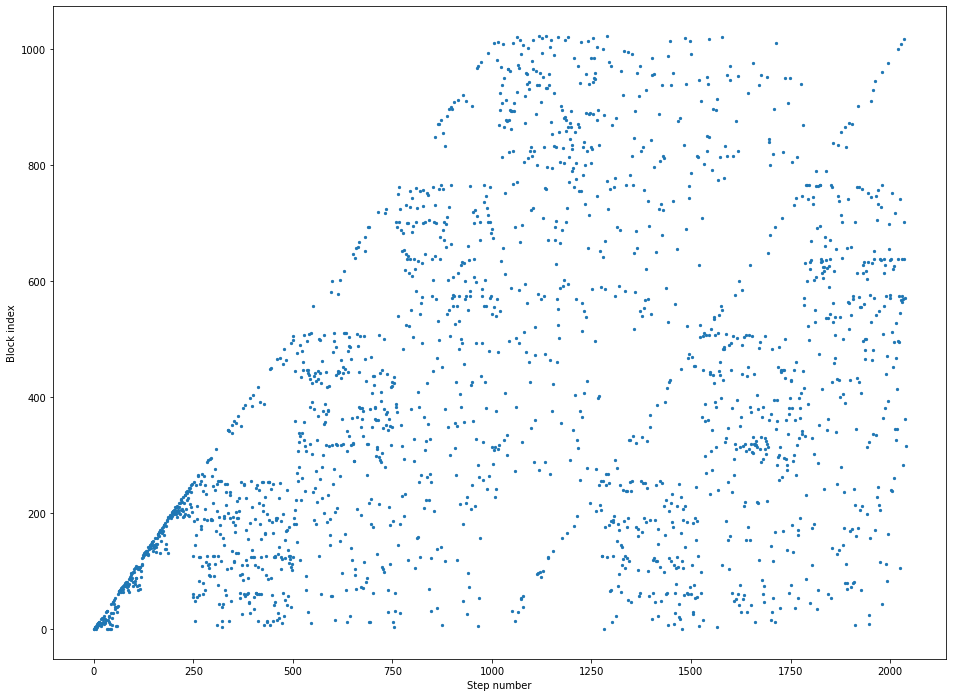

In [ ]:
visualize_for_password(b'passwd', memory_cost=1024, iterations = 2, type_code=ARGON2D)

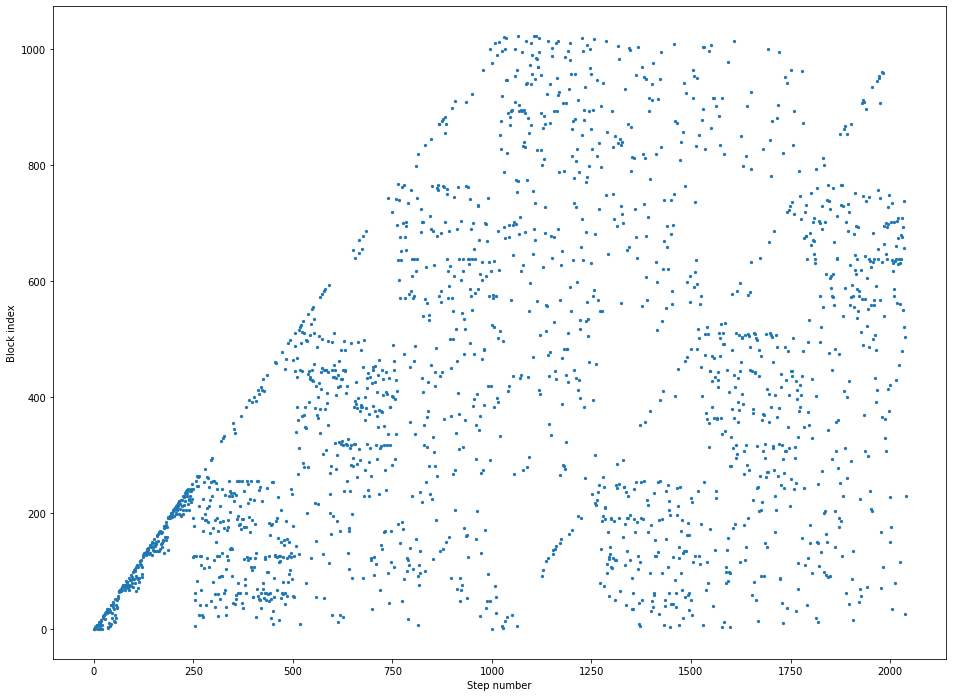

In [ ]:
visualize_for_password(b'passwd', memory_cost=1024, iterations = 2, type_code=ARGON2I)

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

def block_density_plot(password, salt=b"salt", iterations=1, memory_cost=1024, parallelism=4, type_code=ARGON2ID, title=''):
    h, (i_array, j_array) = argon2(password, salt, time_cost=iterations, memory_cost=memory_cost, parallelism=parallelism,
            tag_length=16, secret=b'', associated_data=b'',
            type_code=type_code, threads=1, version=ARGON2_DEFAULT_VERSION,
            use_threads=True)

    plt.figure(figsize=(16, max(parallelism // 4, 2)))
    plt.xlabel('Column')
    plt.ylabel('Lane (row)')
    
    x = j_array
    y = i_array

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    plt.yticks(list(range(parallelism)))
    plt.scatter(x, y, c=z, s=200, edgecolor='none', marker="s")
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.title(title)
    plt.show()

# 1 iteration vs 16 iterations

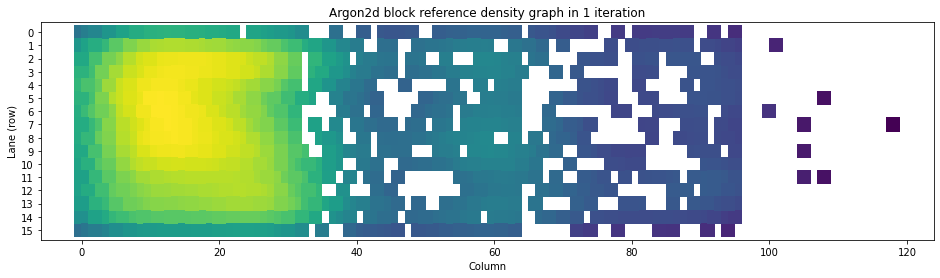

In [ ]:
block_density_plot(b'passwd', memory_cost=2048, iterations = 1, parallelism = 16, type_code=ARGON2D, title='Argon2d block reference density graph in 1 iteration')


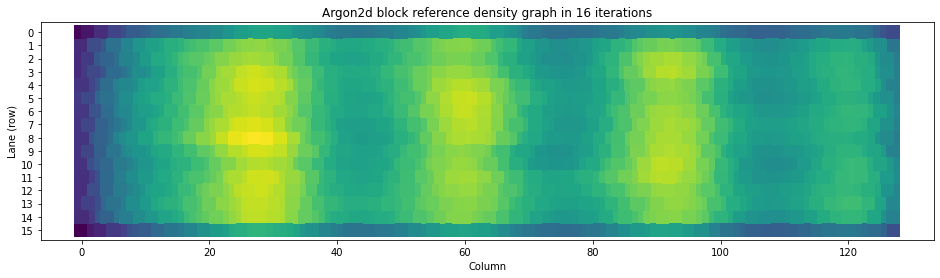

In [ ]:
block_density_plot(b'passwd', memory_cost=2048, iterations = 16, parallelism = 16, type_code=ARGON2D, title='Argon2d block reference density graph in 16 iterations')

# Argon2d vs Argon2i

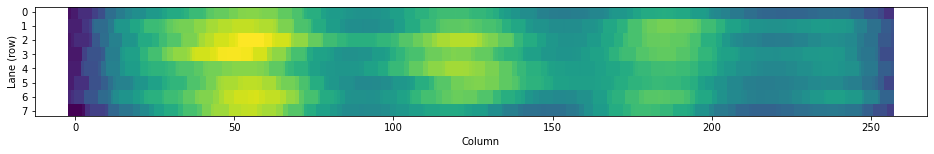

In [ ]:
block_density_plot(b'passwd', memory_cost=2048, iterations = 8, parallelism = 8, type_code=ARGON2I)

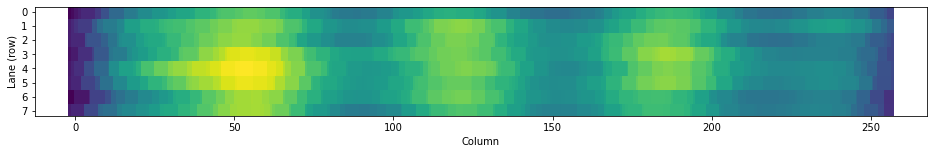

In [ ]:
block_density_plot(b'passwd', memory_cost=2048, iterations = 8, parallelism = 8, type_code=ARGON2D)

# Modifications

In [ ]:
# Util function
# Returns results similar to range(start, stop, step) but works with floats as start/stop/step

def arange(start, stop, step):
    result = []
    val = start
    while val < stop:
        result.append(val)
        val += step
        val = round(val, 6)
        
    return result

arange(2.5, 2.6, 0.01)

[2.5, 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59]

In [ ]:
# Generates exactly $maxIter logistic mapping iteration values for a given point x0 (assuming given r parameter)
# maxIter allows us to stop calculation at some point
# x0 is between 0 and 1.0
# r takes values from 1.0

def logisticMap(x0 = 0.5, r = 3, maxIter = 50):
    xN = x0   
    for i in range(maxIter):
        yield xN
        xN = r * xN * (1 - xN)

In [ ]:
x0 = 0.5
r = 2.5
maxIter = 5
print(list(logisticMap(x0, r, maxIter)))

[0.5, 0.625, 0.5859375, 0.606536865234375, 0.5966247408650815]


In [ ]:
r = 3.7
x0 = 0.7
x1 = 0.71
maxIter = 10

print(list(logisticMap(x0, r, maxIter)))
print(list(logisticMap(x1, r, maxIter)))

[0.7, 0.777, 0.6411027, 0.8513331037950269, 0.46829068565768556, 0.921279721720579, 0.2683365654480165, 0.7264285964388417, 0.7353013356445238, 0.7201431413424416]
[0.71, 0.76183, 0.6713466890700001, 0.8163691549355703, 0.5546690638798066, 0.9139417857816707, 0.29101313254036126, 0.7634006101488073, 0.6682944387209733, 0.8202048330136926]


In [ ]:
# It goes a bit further - this function gets us an array of >>converged<< bifurcated values
# e.g. For a given x0 and r, logistic mapping can converge into ONE OR MORE values
#      we return all of those values, but ONLY those converged values
#      (by simply assuming the lattest values are the converged ones).
#      This work because we try to find the "convergence period"
#      i.e. assuming the period is 4 (the logical mapping sequence converges into 4 different values)
#      the difference between last value and 5th to the last value is expected to be less than $err
#      (beacuse last 4 values are all different convergence points and 5th last value is previous iteration of last convergence point)
# Might not work well with low number of iterations or with too low err parameter.
# Best to keep the default err value and just increase iterations if needed.

def logisticMapConvergenceValues(x0, r, err = 1.0e-3, maxIter = 50):
    values = list(logisticMap(x0, r, maxIter))
    lastVal = values[-1]
    
    for i in range(maxIter - 2, 0, -1):
        if abs(lastVal - values[i]) < err:
            return [round(val, 6) for val in values[i+1:]]

In [ ]:
err = 1.0e-3
x0 = 0.5
r = 3.5
maxIter = 50
print(logisticMapConvergenceValues(x0, r, err, maxIter))

[0.38282, 0.826941, 0.500884, 0.874997]


In [ ]:
# ONLY FOR VISUALIZATION PURPOSES
# This function finds convergence values in a given r value range.
# e.g. For a given x0, if we set minR=2.5, maxR=3.5, step=0.5, it will yield 3 arrays
#     with convergence points at logisticMap(x0, 2.5), logisticMap(x0, 3.0) and logisticMap(x0, 3.5)

def findConvergenceValues(x0, minR, maxR, step=0.1, err=1.0e-3, maxIter=50):
    for i in arange(minR, maxR, step):
        yield logisticMapConvergenceValues(x0, i, err, maxIter)

In [ ]:
err = 1.0e-3
x0 = 0.7
minR = 1.0
maxR = 2.0
maxIter = 100
step = 0.01

#x = arange(minR, maxR, step)
y = list(findConvergenceValues(x0, minR, maxR, step, err, maxIter))
print(y)

[[0.009435], [0.015146], [0.02227], [0.030373], [0.039007], [0.047845], [0.056694], [0.065455], [0.074087], [0.082573], [0.090911], [0.0991], [0.107143], [0.115044], [0.122807], [0.130435], [0.137931], [0.145299], [0.152542], [0.159664], [0.166667], [0.173554], [0.180328], [0.186992], [0.193548], [0.2], [0.206349], [0.212598], [0.21875], [0.224806], [0.230769], [0.236641], [0.242424], [0.24812], [0.253731], [0.259259], [0.264706], [0.270073], [0.275362], [0.280576], [0.285714], [0.29078], [0.295775], [0.300699], [0.305556], [0.310345], [0.315068], [0.319728], [0.324324], [0.328859], [0.333333], [0.337748], [0.342105], [0.346405], [0.350649], [0.354839], [0.358974], [0.363057], [0.367089], [0.371069], [0.375], [0.378882], [0.382716], [0.386503], [0.390244], [0.393939], [0.39759], [0.401198], [0.404762], [0.408284], [0.411765], [0.415205], [0.418605], [0.421965], [0.425287], [0.428571], [0.431818], [0.435028], [0.438202], [0.441341], [0.444444], [0.447514], [0.450549], [0.453552], [0.456

[0.949904, 0.180827, 0.562889, 0.934971, 0.231041, 0.675111, 0.833477, 0.527414, 0.947144, 0.190236, 0.585376, 0.922302, 0.272313, 0.753002, 0.706762, 0.787549, 0.6358, 0.879922, 0.401505, 0.913136, 0.301412, 0.800139, 0.607683, 0.905937, 0.323818, 0.832047, 0.53103, 0.946341, 0.192962, 0.591765, 0.918001, 0.286046, 0.776051, 0.660425, 0.852202, 0.478623, 0.948264, 0.186427, 0.576354, 0.927846, 0.254401, 0.720789, 0.764759, 0.683631, 0.821863, 0.556336, 0.93794, 0.221194, 0.654615, 0.859158, 0.45982, 0.943865, 0.201338, 0.611044, 0.903143, 0.332406, 0.843267, 0.502237, 0.949981, 0.180565, 0.562253, 0.935273, 0.230041, 0.673063, 0.836186, 0.520519, 0.9484, 0.185962, 0.575245, 0.928485, 0.252321, 0.71689, 0.771244, 0.670422, 0.839634, 0.511665, 0.949483, 0.182267, 0.566374, 0.933259, 0.236689, 0.686537, 0.817775, 0.566272, 0.933311, 0.236519, 0.686196, 0.818258, 0.565104, 0.933894, 0.234598, 0.682336, 0.823664, 0.551918, 0.939757, 0.215131, 0.64163, 0.873776, 0.419108, 0.925135, 0.26319,

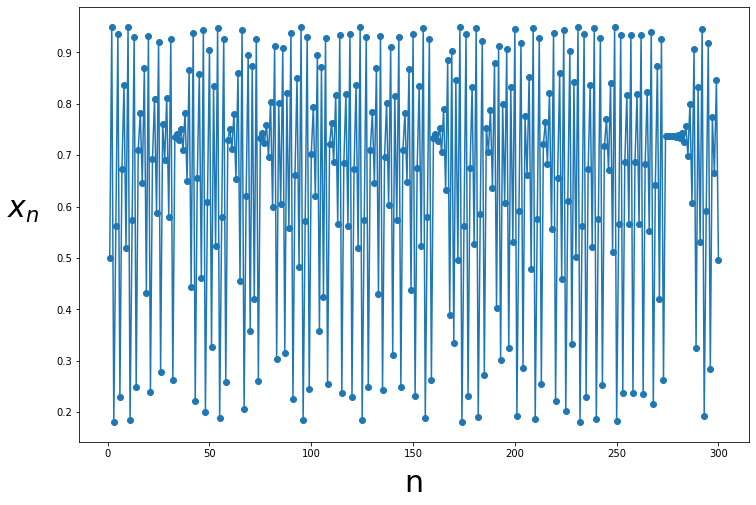

In [ ]:
err = 1.0e-3
x0 = 0.5
r = 3.8000001
maxIter = 300

x = range(1, maxIter + 1)
y = list(logisticMap(x0, r, maxIter))

plt.figure(figsize=(12, 8))
plt.scatter(x, y)
plt.plot(x, y)
plt.xlabel('n', fontsize=30, labelpad = 10)
plt.ylabel('$x_n$', fontsize=30, rotation=0, labelpad = 33)

print(logisticMapConvergenceValues(x0, r, err, maxIter))

In [ ]:
import struct, math, sys

def calculate_logistic_mapping_values(r=3.7, x0=0.71, maxIter=100):
    return list(reversed(list(logisticMap(x0, r, maxIter))))

def generate_logistic_mapping_values(r=3.7, x0=0.71, maxIter=100):
    initial_list = calculate_logistic_mapping_values(r, x0, maxIter)
    while True:
        if len(initial_list) == 1:
            seed_val = initial_list.pop()
            integer_from_seed_val = linear_mapping(seed_val)
            x0_float = reverse_linear_mapping(integer_from_seed_val, min_val=0.0, max_val=1.0, mod=r)
            r_float = reverse_linear_mapping(integer_from_seed_val, min_val=3.5, max_val=3.9, mod=seed_val)
            initial_list = calculate_logistic_mapping_values(r_float, x0_float, maxIter)
        yield initial_list.pop()
        
# Mapping [0.0, 1.0] -> [0, 2^16]
def linear_mapping(zero_to_one_float):
    if zero_to_one_float > 1.0 or zero_to_one_float < 0.0:
        raise Exception(f'Got float lower than 0.0 or greater than 1.0: {zero_to_one_float}')
    
    return int(zero_to_one_float * 2**16)

# Mapping [0, +inf] -> [min_val, max_val]
def reverse_linear_mapping(some_integer, min_val=0.0, max_val=1.0, mod=1.0):
    modulo_cap = 2 ** 18
    return (((some_integer * mod) % modulo_cap) * (max_val-min_val) / modulo_cap) + min_val

# Modified argon2

In [ ]:
""" Modified Python implementation of the Argon2 password hash. """


import six
from six.moves import range
from six import BytesIO

import struct
import binascii
import multiprocessing
import multiprocessing.dummy

__all__ = [
    'argon2',
    'ARGON2D',
    'ARGON2I',
    'ARGON2_DEFAULT_VERSION',
    'ARGON2_VERSIONS',
    'Argon2Error',
    'Argon2ParameterError']

ARGON2D  = 0
ARGON2I  = 1
ARGON2ID = 2

ARGON2_VERSIONS = (0x10, 0x13)
ARGON2_DEFAULT_VERSION = ARGON2_VERSIONS[-1]
ARGON2_TYPES = (ARGON2D, ARGON2I, ARGON2ID)

i_primes = []
j_primes = []

class Argon2Error(Exception):
    pass

class Argon2ParameterError(Argon2Error):
    pass

def argon2_mod(password, salt, time_cost, memory_cost, parallelism,
                tag_length=32, secret=b'', associated_data=b'',
                type_code=ARGON2I, threads=None, version=ARGON2_DEFAULT_VERSION,
                use_threads=False, mod_func=lambda x,y: x+y):
    """ Compute the Argon2 hash for *password*.

    :param bytes password: Password to hash
    :param bytes salt: A salt.  Should be random and different for each
        password.
    :param int time_cost: Number of iterations to use.
    :param int memory_cost: Amount of kibibytes of memory to use.
    :param int parallelism: Amount of threads that can contribute to
        the computation of the hash at the same time.

    Optional arguments:

    :param int tag_length: Length of the hash returned
    :param bytes secret: Optional secret to differentiate hash
    :param bytes associated_data: Optional associated data
    :param int type: variant of argon2 to use.  Either ARGON2I or ARGON2D
    :param int threads: number of threads to use to compute the hash.
    :param bool use_threads: if true, signal multiprocessing to use threads
        rather than processes.
    :param int version: version of argon2 to use.  At the moment either
        0x10 for v1.0 or 0x13 for v1.3

    :rtype: bytes """
    if threads is None:
        threads = parallelism
    if parallelism <= 0:
        raise Argon2ParameterError("parallelism must be strictly positive")
    if threads <= 0:
        raise Argon2ParameterError("threads must be strictly positive")
    if time_cost <= 0:
        raise Argon2ParameterError("time_cost must be strictly positive")
    if memory_cost < 8 * parallelism:
        raise Argon2ParameterError("memory_cost can't be less than 8"
                                    " times the number of lanes")
    if type_code not in ARGON2_TYPES:
        raise Argon2ParameterError("type_code %s not supported" % type_code)
    if version not in ARGON2_VERSIONS:
        raise Argon2ParameterError("version %s not supported" % version)
        
    i_primes = []
    j_primes = []

    threads = min(parallelism, threads)

    if threads == 1:
        worker_pool = None
    else:
        if use_threads:
            Pool = multiprocessing.dummy.Pool
        else:
            Pool = multiprocessing.Pool
        worker_pool = Pool(processes=threads)

    # Compute the pre-hasing digest
    h = Blake2b()
    h.update(struct.pack("<iiiiii", parallelism,
                                    tag_length,
                                    memory_cost,
                                    time_cost,
                                    version,
                                    type_code))
    h.update(struct.pack("<i", len(password)))
    h.update(password)
    h.update(struct.pack("<i", len(salt)))
    h.update(salt)
    h.update(struct.pack("<i", len(secret)))
    h.update(secret)
    h.update(struct.pack("<i", len(associated_data)))
    h.update(associated_data)
    H0 = h.digest()

    m_prime = (memory_cost // (4 * parallelism)) * (4 * parallelism)
    q = m_prime // parallelism  # lane_length
    segment_length = q // 4

    # Allocate the matrix.
    B = [[None for j in range(q)] for i in range(parallelism)]

    # The blocks in Argon2 are arranged in a matrix.  For each thread,
    # there is a row, which is also called a lane.  The number of
    # columns depends on the memory_cost.
    # There will be time_cost passes over the whole matrix.
    # The colums are put into groups of four, called slices.
    # The intersection of a lane with a slice is called a segment.
    # The matrix is filled one slice at the time.  The segments within
    # a slice can be computed in parallel.
    for t in range(time_cost):
        for segment in range(4):
            if not worker_pool:
                for i in range(parallelism):
                    _, (i_indexes, j_indexes) = _mod_fill_segment(B, t, segment, i, type_code, segment_length,
                                H0, q, parallelism, m_prime, time_cost, version, mod_func)
                    i_primes += i_indexes
                    j_primes += j_indexes
                    #print(f'Result of lane {i} and segment {segment}: {len(i_indexes)}')
                continue

            handles = [None]*parallelism
            for i in range(parallelism):
                handles[i] = worker_pool.apply_async(_mod_fill_segment,
                            (B, t, segment, i, type_code, segment_length, H0,
                                q, parallelism, m_prime, time_cost, version, mod_func))
            for i in range(parallelism):
                new_blocks, (i_indexes, j_indexes) = handles[i].get()
                
                i_primes += i_indexes
                j_primes += j_indexes

                for index in range(segment_length):
                    B[i][segment * segment_length + index] = new_blocks[index]

    if worker_pool:
        # don't let workers sit around until pool is GC'd
        worker_pool.close()

    B_final = b'\0' * 1024

    for i in range(parallelism):
        B_final = xor1024(B_final, B[i][q-1])

    return _H_prime(B_final, tag_length), (i_primes, j_primes)

def _mod_fill_segment(B, t, segment, i, type_code, segment_length, H0,
                        q, parallelism, m_prime, time_cost, version, mod_func=lambda x,y: x+y):
    # Argon2i computes a bunch of pseudo-random numbers
    # for every segment.
    data_independant = ((type_code == ARGON2I)
            or (type_code == ARGON2ID and t == 0 and segment <= 1))
    if data_independant:
        # See `generate_addresses' in reference implementation
        # and section 3.3 of the specification.
        pseudo_rands = []
        ctr = 0  # `i' in the specification
        while len(pseudo_rands) < segment_length:
            ctr += 1
            address_block = _compress(b'\0'*1024, _compress(b'\0'*1024,
                                struct.pack('<QQQQQQQ', t, i, segment, m_prime,
                                                    time_cost, type_code, ctr)
                                    + b'\0'*968))
            for addr_i in range(0, 1024, 8):
                pseudo_rands.append(struct.unpack('<II',
                            address_block[addr_i:addr_i+8]))
                
    i_primes = []
    j_primes = []
        
    logistic_mapping_generator = None

    for index in range(segment_length):
        j = segment * segment_length + index
        if t == 0 and j < 2:
            # First two columns are special.
            B[i][j] = _H_prime(H0 + struct.pack('<II', j, i), 1024)
            continue

        # See `section 3.3. Indexing' of argon2 spec.
        # First, we derive two pseudo-random values from the current
        # state.  This is where Argon2i and Argon2d differ.
        if data_independant:
            J1, J2 = pseudo_rands[index]
        else:
            J1, J2 = struct.unpack_from('<II', B[i][(j-1)%q][:8])
            
        
        ######################################################################################################################
        
        if logistic_mapping_generator == None:
            init_r = reverse_linear_mapping(J1, 3.5, 3.9)
            init_x0 = reverse_linear_mapping(J2, 0.0, 1.0)
            logistic_mapping_generator = generate_logistic_mapping_values(init_r, init_x0, 32)

        next_logistic_mapping_val = next(logistic_mapping_generator)

        if next_logistic_mapping_val < 0.0 or next_logistic_mapping_val > 1.0:
            print(f'ERROR: {next_logistic_mapping_val}')
        
        integer_from_logistic_mapping_val = linear_mapping(next_logistic_mapping_val)

        J1 = mod_func(J1, integer_from_logistic_mapping_val)
        J2 = mod_func(J2, integer_from_logistic_mapping_val)
        
        ######################################################################################################################

        # Using the pseudo-random J1 and J2, we pick a reference
        # block to mix with the previous one to create the next.
        i_prime = i if t == 0 and segment == 0 else J2 % parallelism

        if t == 0:
            if segment == 0 or i == i_prime:
                ref_area_size = j - 1
            elif index == 0:
                ref_area_size = segment * segment_length - 1
            else:
                ref_area_size = segment * segment_length
        elif i == i_prime:  # same_lane
            ref_area_size = q - segment_length + index - 1
        elif index == 0:
            ref_area_size = q - segment_length - 1
        else:
            ref_area_size = q - segment_length

        rel_pos = (J1 ** 2) >> 32
        rel_pos = ref_area_size - 1 - ((ref_area_size * rel_pos) >> 32)
        start_pos = 0

        if t != 0 and segment != 3:
            start_pos = (segment + 1) * segment_length
        j_prime = (start_pos + rel_pos) % q
        
        i_primes += [i_prime]
        j_primes += [j_prime]

        # Mix the previous and reference block to create
        # the next block.
        new_block = _compress(B[i][(j-1)%q], B[i_prime][j_prime])
        if t != 0 and version == 0x13:
            new_block = xor1024(B[i][j], new_block)
        B[i][j] = new_block

    # If we are run in a separate thread, then B is a copy.  Return changes.
    return (B[i][segment*segment_length:(segment+1)*segment_length], (i_primes, j_primes))


# xor1024: XOR two 1024 byte blocks with eachother.

if six.PY3:
    def xor1024(a, b):
        return (int.from_bytes(a, byteorder='little') ^
                int.from_bytes(b, byteorder='little')).to_bytes(
                                 1024, byteorder='little')
else:
    _1024B_STRUCT = struct.Struct('Q'*128)
    def xor1024(a, b):
        a2 = _1024B_STRUCT.unpack(a)
        b2 = list(_1024B_STRUCT.unpack(b))
        for i in xrange(128):
            b2[i] ^= a2[i]
        return _1024B_STRUCT.pack(*b2)

# Used block indexes visualization (standard vs modified)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def visualize_point_different_colors(arrays_of_ys, labels=['argon2', 'mod2-argon2 (+)', 'mod2-argon2 (xor)']):
  # colors = cm.rainbow(np.linspace(0, 1, len(arrays_of_ys)))
  colors = ['b', 'r', 'g']

  plt.figure(figsize=(22,14))
  plt.xlabel('Step number')
  plt.ylabel('Block index')

  for ys, color in zip(arrays_of_ys, colors):
    plt.scatter(range(len(ys)), ys, color=color, s=5)
    plt.legend(labels)

In [ ]:
def compare_indexes_visualization(password, salt=b"salt", iterations=1, memory_cost=32, parallelism=4, type_code=ARGON2ID):
  h, (i_array, j_array) = argon2(password, salt, time_cost=iterations, memory_cost=memory_cost, parallelism=parallelism,
              tag_length=16, secret=b'', associated_data=b'',
              type_code=type_code, threads=1, version=ARGON2_DEFAULT_VERSION,
              use_threads=True)

  one_dim_indexes1 = flatten_indexes(i_array, j_array, memory_cost, parallelism)

  h, (i_array, j_array) = argon2_mod(password, salt, time_cost=iterations, memory_cost=memory_cost, parallelism=parallelism,
              tag_length=16, secret=b'', associated_data=b'',
              type_code=type_code, threads=1, version=ARGON2_DEFAULT_VERSION,
              use_threads=True, mod_func=lambda x,y:x+y)

  one_dim_indexes2 = flatten_indexes(i_array, j_array, memory_cost, parallelism)

  h, (i_array, j_array) = argon2_mod(password, salt, time_cost=iterations, memory_cost=memory_cost, parallelism=parallelism,
              tag_length=16, secret=b'', associated_data=b'',
              type_code=type_code, threads=1, version=ARGON2_DEFAULT_VERSION,
              use_threads=True, mod_func=lambda x,y:x^y)

  one_dim_indexes3 = flatten_indexes(i_array, j_array, memory_cost, parallelism)

  visualize_point_different_colors([one_dim_indexes1, one_dim_indexes2, one_dim_indexes3])


In [ ]:
password = b'ggKNnHtdm^Q28N&7'
memory_cost = 512
iterations = 8
type_code = ARGON2D

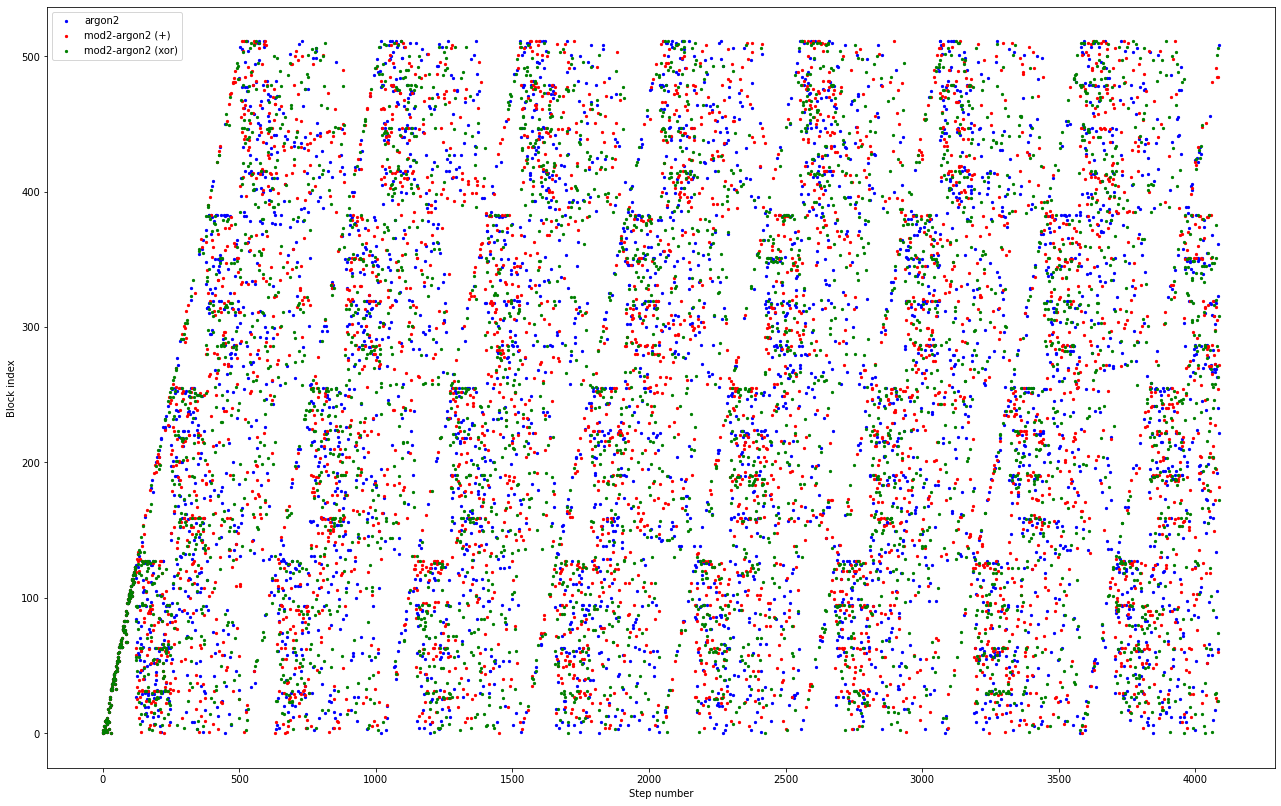

In [ ]:
compare_indexes_visualization(password, memory_cost=memory_cost, iterations=iterations, type_code=type_code)

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

def mod_block_density_plot(password, salt=b"salt", iterations=1, memory_cost=1024, parallelism=4, type_code=ARGON2ID, mod_func=lambda x,y:x+y, title=''):
    h, (i_array, j_array) = argon2_mod(password, salt, time_cost=iterations, memory_cost=memory_cost, parallelism=parallelism,
            tag_length=16, secret=b'', associated_data=b'',
            type_code=type_code, threads=1, version=ARGON2_DEFAULT_VERSION,
            use_threads=True, mod_func=mod_func)

    plt.figure(figsize=(16, max(parallelism // 4, 2)))
    plt.xlabel('Column')
    plt.ylabel('Lane (row)')
    
    x = j_array
    y = i_array

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    plt.yticks(list(range(parallelism)))
    plt.scatter(x, y, c=z, s=200, edgecolor='none', marker="s")
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.title(title)
    plt.show()

# Block usage density (standard vs modified)

In [ ]:
password = b'!P!DU#cUkD8sJ^R&'
memory_cost = 2048
iterations = 8
parallelism = 32
type_code=ARGON2D

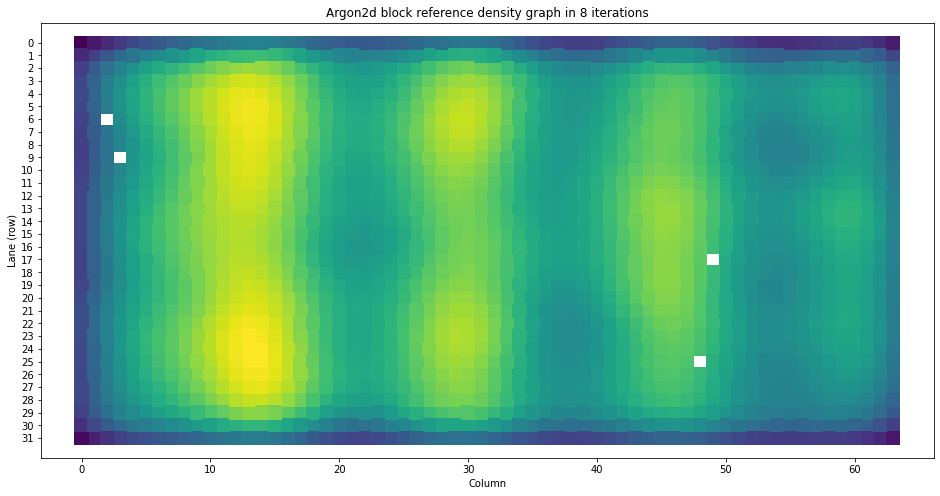

In [ ]:
block_density_plot(password, memory_cost=memory_cost, iterations=iterations, parallelism=parallelism, type_code=ARGON2D,
                   title=f'Argon2d block reference density graph in {iterations} iterations')

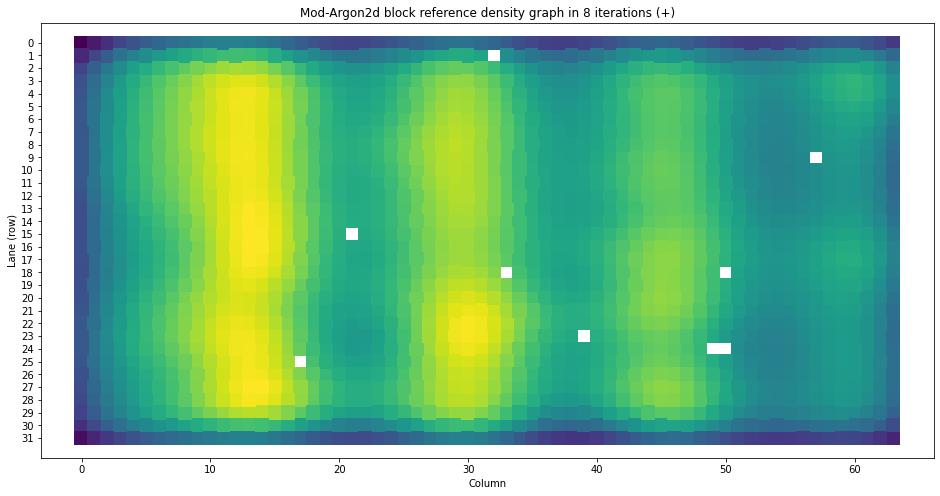

In [ ]:
mod_block_density_plot(password, memory_cost=memory_cost, iterations=iterations, parallelism=parallelism, type_code=ARGON2D,
                       mod_func=lambda x,y:x+y, title=f'Mod-Argon2d block reference density graph in {iterations} iterations (+)')

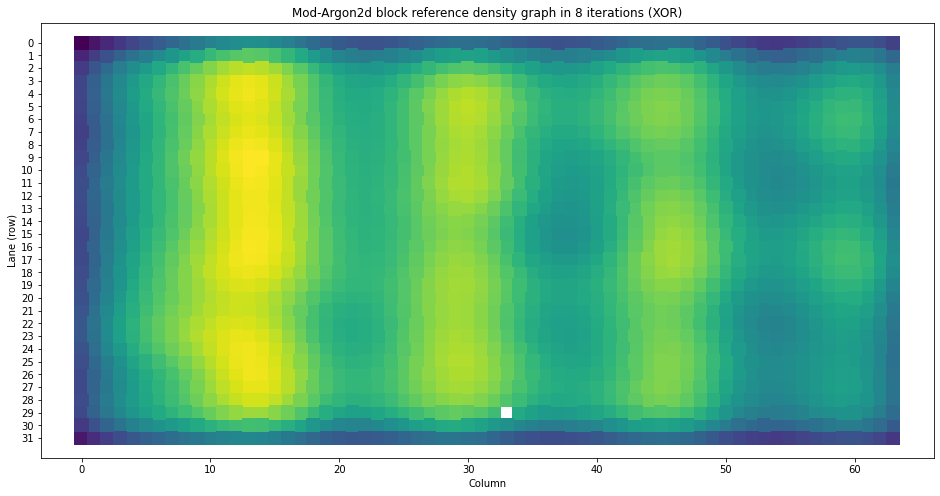

In [ ]:
mod_block_density_plot(password, memory_cost=memory_cost, iterations=iterations, parallelism=parallelism, type_code=ARGON2D,
                       mod_func=lambda x,y:x^y, title=f'Mod-Argon2d block reference density graph in {iterations} iterations (XOR)')

In [ ]:
# TODO wizualizacja różnicowa w/w wykresów